# Поиск похожих слов с использованием word2vec 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
random.seed(1228)

%matplotlib inline

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [16]:
data = pd.read_csv("../data/articles_lemmatized_noSW.csv", usecols = ['headline', 'body', 'topic'])

In [17]:
data.head()

,headline,body,topic
0,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг пл...,IT
2,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,9 беспроигрышных подарков для мужчины,каждый год накануне февраль возникать сложный ...,IT
4,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто


In [18]:
texts = []
for index, row in data.iterrows():
    try:
        texts.append(row.body.split())
    except:
        continue

Обучение модели:

In [5]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("izv_w2v.model")

Using TensorFlow backend.


CPU times: user 2min 24s, sys: 2.11 s, total: 2min 26s
Wall time: 51.9 s


Загружаем обученную модель (для скорости):

In [2]:
from gensim.models import Word2Vec
model = Word2Vec.load("izv_w2v.model") 

C:\Users\sanek\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


    1. Найдите синонимы для какого-нибудь слова:

In [4]:
model.wv.most_similar("олимпиада")

[('ои', 0.7740594744682312),
 ('паралимпиада', 0.77059006690979),
 ('соревнование', 0.7596844434738159),
 ('рио', 0.7338443994522095),
 ('пхенчхан', 0.6549415588378906),
 ('игра', 0.6463425755500793),
 ('олимпийский', 0.6433990597724915),
 ('универсиада', 0.6284902095794678),
 ('состязание', 0.6180386543273926),
 ('спортсмен', 0.6154279112815857)]

    2. Найдите ассоциации вида (мужчина : король = женщина : королева)

In [5]:
model.wv.most_similar(positive=["путин","сша"], negative=["россия"])

[('обама', 0.5208215713500977),
 ('американский', 0.44001081585884094),
 ('чиркин', 0.41713932156562805),
 ('трамп', 0.4133683443069458),
 ('барак', 0.4068254828453064),
 ('вкс', 0.40586012601852417),
 ('чижов', 0.3993554711341858),
 ('комоед', 0.3955763280391693),
 ('бызов', 0.39516061544418335),
 ('алекно', 0.39129528403282166)]

    3. Задайте список слов и найдите лишнее в нем:

In [7]:
model.wv.doesnt_match("германия россия сша трамвай".split())

'трамвай'

    4. Создайте список top_words и запишите в него N самых частых слов

In [8]:
N = 500
top_words = []

In [9]:
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(N):
    top_words.append(i[0])
print(top_words)

NameError: name 'texts' is not defined

    5. Постройте семантическую карту и найдите на ней интересные кластеры слов 

In [21]:
top_words_vec = model[top_words]

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

    6. Кластеризуйте эмбеддинги, постройте дендрограмму и найдите интересные кластеры 

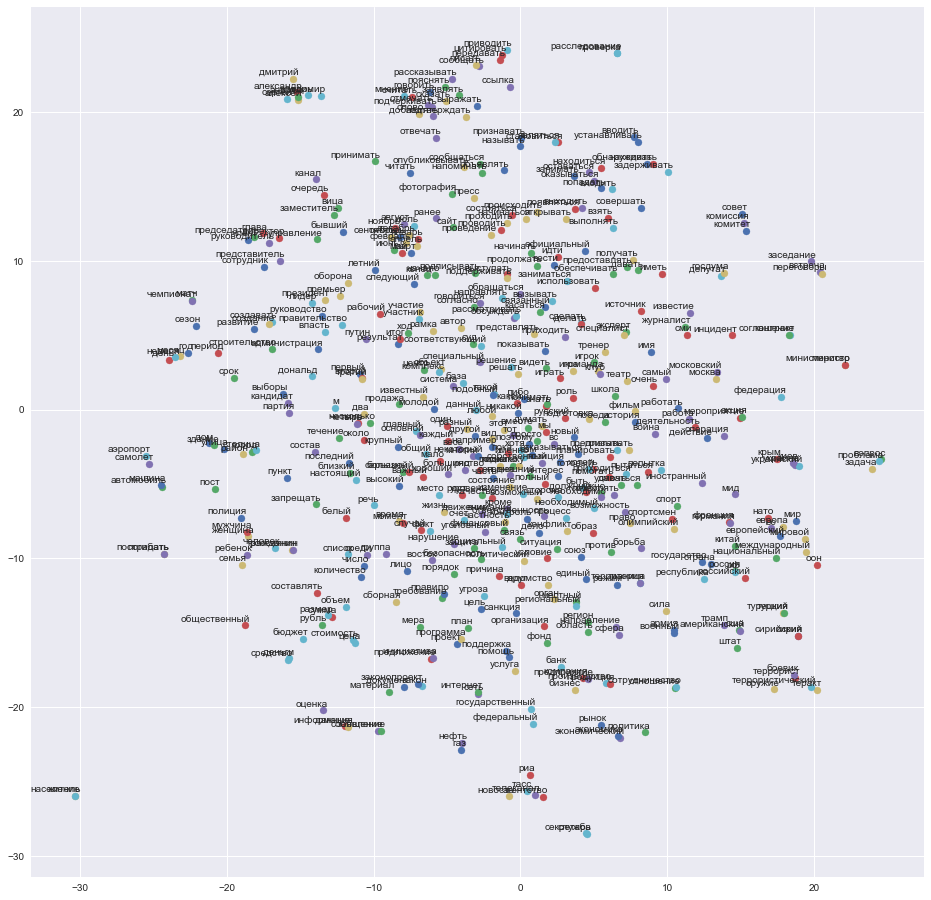

In [23]:
x = []
y = []
for value in top_words_tsne:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(top_words[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

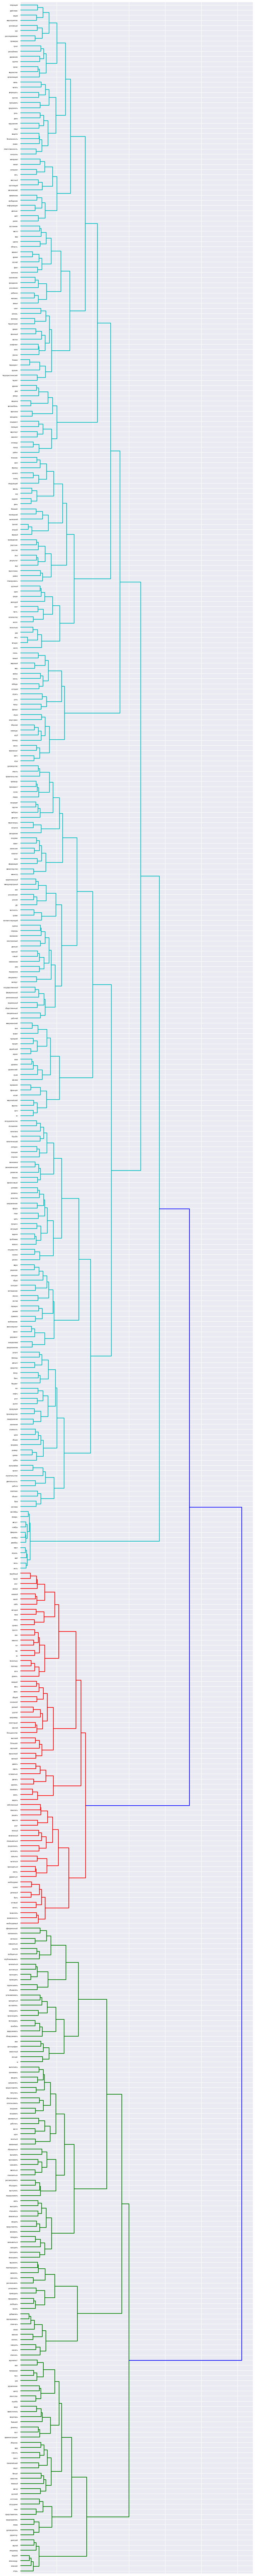

In [16]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters